## Practice


Note: this notebook must be run from the root of the [LinkPredict](https://github.com/RecSysTeam/LinkPredict) repository.

In [1]:
from src.data import extract_vault, holdout, delete_nodes_without_links

from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertModel, VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

import markdown as md
from bs4 import BeautifulSoup
import PyPDF2
from PIL import Image

import os, shutil
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
from pathlib import Path

/home/demin/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/demin/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR = os.getcwd()
DIR

'/home/demin/prac/LinkPredict'

1. Extract data from the vault

In [3]:
vault = extract_vault('./vaultes/obsidian-hub/')

Front matter not populated for radekkozak.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7f9ecd2d2ca0>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7f9ecd2d0770>)
Front matter not populated for radekkozak.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7f9ecd2d8770>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7f9ecd2da9d0>)
Front matter not populated for jaynguyens.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7f9ecd1049a0>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7f9ecd106930>)
Front matter not populated for jaynguyens.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7f9ecd1054e0>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7f9ecd106c00>)
Front matter not populated for beaussan.md: ScannerError('while scanning for

In [4]:
df = vault.get_all_file_metadata()
df

,rel_filepath,abs_filepath,file_exists,n_backlinks,n_wikilinks,n_tags,n_embedded_files,modified_time,graph_category
file,,,,,,,,,
,NaN,NaN,False,18,NaN,NaN,NaN,NaT,nonexistent
obsidian-front-matter-title-plugin,02 - Community Expansions/02.05 All Community ...,vaultes/obsidian-hub/02 - Community Expansions...,True,3,2.0,1.0,1.0,2023-08-09 06:29:53.363519907,note
charliecm,01 - Community/People/charliecm.md,vaultes/obsidian-hub/01 - Community/People/cha...,True,4,1.0,0.0,0.0,2023-08-09 06:29:53.287518024,note
02 - Community Expansions/02.05 All Community Expansions/Plugins/obsidian-custom-frames,NaN,NaN,False,1,NaN,NaN,NaN,NaT,nonexistent
01 - Community/People/louis030195,NaN,NaN,False,1,NaN,NaN,NaN,NaT,nonexistent
...,...,...,...,...,...,...,...,...,...
css-obsidian-layout.png,NaN,NaN,False,1,NaN,NaN,NaN,NaT,nonexistent
Everblush,NaN,NaN,False,2,NaN,NaN,NaN,NaT,nonexistent
01 - Community/People/hipstersmoothie,NaN,NaN,False,4,NaN,NaN,NaN,NaT,nonexistent


In [5]:
df.index.value_counts()

file
Everblush                                                                                   2
g-bauer                                                                                     2
01 - Community/People/hipstersmoothie                                                       2
signynt                                                                                     2
css-obsidian-layout.png                                                                     2
                                                                                           ..
Breadcrumbs                                                                                 1
02 - Community Expansions/02.05 All Community Expansions/Plugins/discordian-plugin          1
02 - Community Expansions/02.05 All Community Expansions/Plugins/obsidian-budget-wysiwyg    1
obsidian-vault-statistics-plugin                                                            1
02 - Community Expansions/02.05 All Community Expansion

In [6]:
delete_nodes_without_links(vault.graph)

deleted 72 nodes from graph


In [7]:
# quite sparse!
A = nx.adjacency_matrix(vault.graph)
A.nnz / A.shape[0] ** 2

0.00037938032721357667

2. Construct new relations between nodes

In [8]:
# Parse text in the files from the vault.
# Adapted from bert_lightfm.ipynb

def get_text_from_html(html):
    soup = BeautifulSoup(html, features="html.parser")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text

def get_text_from_markdown(filepath):
    with open(filepath, 'r') as f:
        text = f.read()
        html = md.markdown(text)
        text = get_text_from_html(html)
    return text

def get_text_from_pdf(filepath):
    with open(filepath, 'rb') as f:
        pdfReader = PyPDF2.PdfReader(f)
        text = ""
        
        for page in pdfReader.pages:
            text += page.extract_text()
            all_images.extend(page.images)
    return text

def get_images_from_pdf(filepath):
    with open(filepath, 'rb') as f:
        pdfReader = PyPDF2.PdfReader(f)
        images = []
        
        for page in pdfReader.pages:
            for image_file in page.images:
                images.append(Image.open(io.BytesIO(image_file.data)))
    return images

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = BertModel.from_pretrained("bert-base-multilingual-cased")

In [10]:
@torch.no_grad()
def encode_text(text):
    encoded_input = tokenizer_bert(text, truncation=True, return_tensors='pt')
    output = model_bert(**encoded_input)
    return output.pooler_output.cpu().numpy()[0]

In [12]:
# Compute some embedding for nodes in the initial graph
#
# Compute emdeddings using the source text of the files. 

# embeddings = []

# for path in tqdm(df["abs_filepath"].dropna()):
#     extension = str(path).split('.')[-1]
#     if extension == 'md':
#         text = get_text_from_markdown(path)
#         embeddings.append(encode_text(text))
#     else:
#         pass

In [13]:
# Compute emdeddings using the filenames.
embeddings_filenames = []

for text in tqdm(vault.graph.nodes):
    embeddings_filenames.append(encode_text(text))

100%|██████████| 4797/4797 [02:37<00:00, 30.43it/s]


In [15]:
corrs = np.corrcoef(embeddings_filenames)

In [16]:
def trivial_relations(vault):
    rows_list = []
    for n, nbrs in vault.graph.adj.items():
        for nbr, eattr in nbrs.items():
            n = n.strip().replace(' ', '_')
            nbr = nbr.strip().replace(' ', '_')
            if n == "" or nbr == "":
                continue
            dict1 = {'source': n, 'relation': f'/neighbor', 'target': nbr}
            dict2 = {'source': nbr, 'relation': '/neighbor_reverse', 'target': n}
            rows_list.append(dict1)
            rows_list.append(dict2)
        
    kg_df = pd.DataFrame(rows_list, columns=['source', 'relation', 'target'])
    return kg_df

In [17]:
def relations_from_correlations(vault, corrs):
    rows_list = []
    for (i, n) in enumerate(vault.graph.nodes()):
        for (j, m) in enumerate(vault.graph.nodes()):
            if n == m:
                continue
            if corrs[i, j] > 0.9:
                dict1 = {'source': n, 'relation': f'/similar_title', 'target': m}
                dict2 = {'source': m, 'relation': f'/similar_title_reverse', 'target': n}
                rows_list.append(dict1)
                rows_list.append(dict2)
                
    kg_df = pd.DataFrame(rows_list, columns=['source', 'relation', 'target'])
    return kg_df    

In [18]:
kg_df1 = relations_from_correlations(vault, corrs)
kg_df2 = trivial_relations(vault)
kg_df = pd.concat([kg_df1, kg_df2])

In [24]:
# plot 200 entries with similar labels for the sake of sanity check.
kg_graph = nx.from_pandas_edgelist(kg_df[0:200], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
kg_graph.number_of_nodes(), kg_graph.number_of_edges(), 

(101, 200)

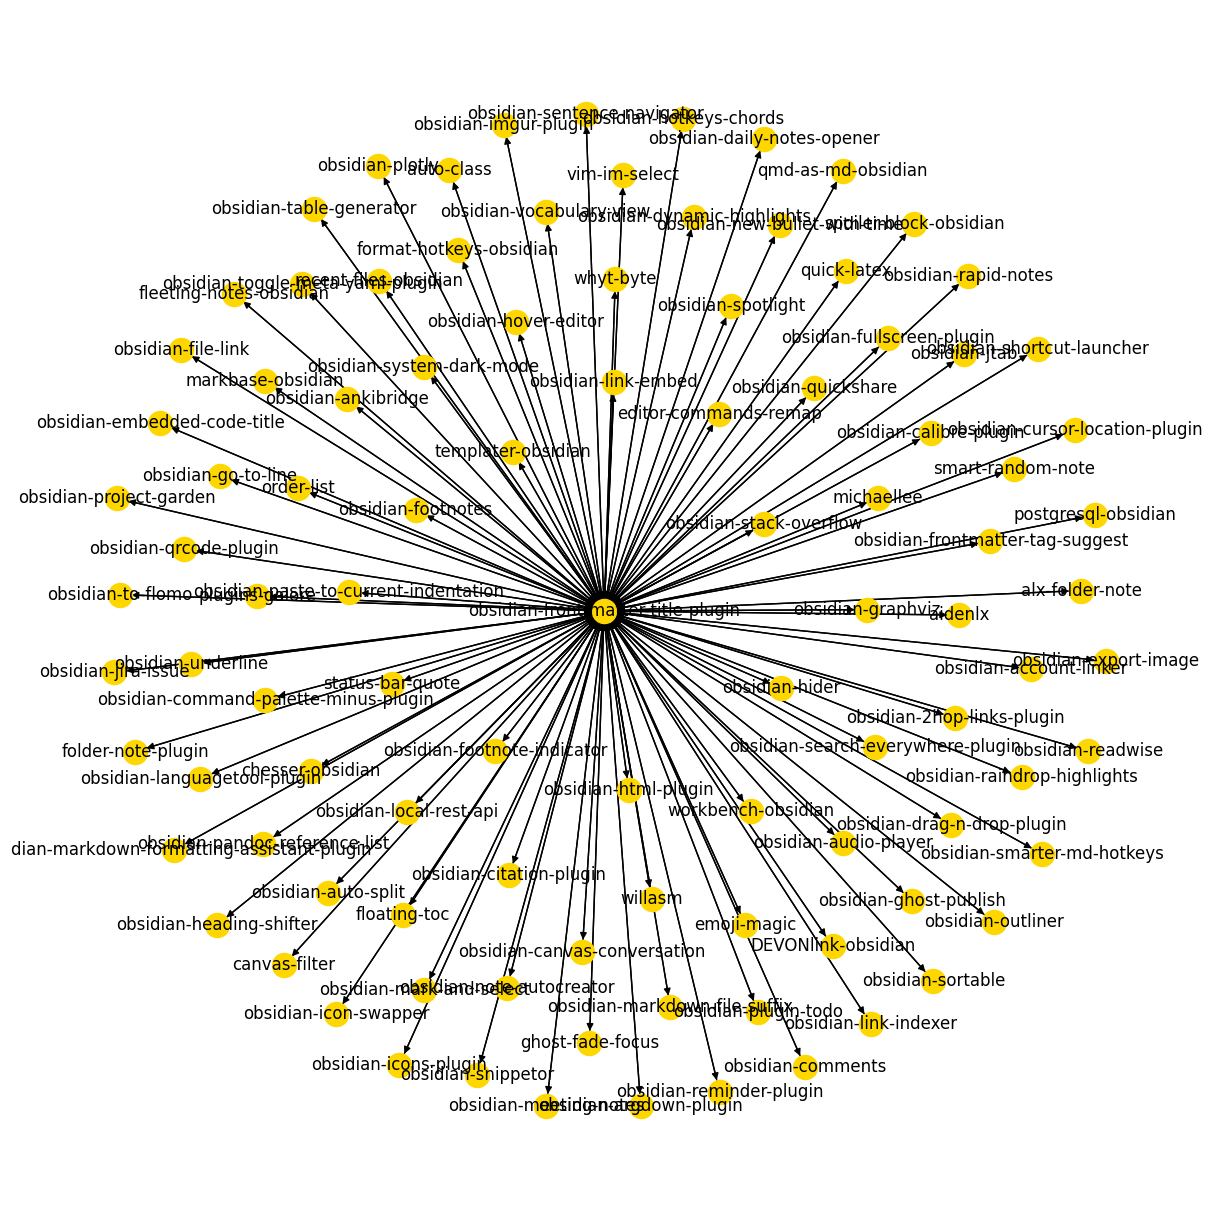

In [25]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(kg_graph)
nx.draw(kg_graph, with_labels=True, node_color='gold', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

3. Dump the dataset to disk

In [26]:
def train_test_val_split(df, **kwargs):
    test_size = kwargs.get('test_size', 0.2)
    val_size = kwargs.get('val_size', 0.1)
    shuffle = kwargs.get('shuffle', False)
    df_train, df_test = train_test_split(kg_df, test_size=test_size, shuffle=shuffle)
    df_train, df_val = train_test_split(df_train, test_size=val_size * 1 / (1 - test_size), shuffle=shuffle)
    return df_train, df_test, df_val

In [27]:
df_train, df_test, df_val = train_test_val_split(kg_df, shuffle=False)
df_train.shape, df_test.shape, df_val.shape

((20358261, 3), (5816647, 3), (2908324, 3))

In [28]:
dataset_title = "dummy-dummy"
Path(DIR + f"/{dataset_title}/").mkdir(parents=True, exist_ok=True)

np.savetxt(DIR + f"/{dataset_title}/test.txt", df_test.values, fmt='%s', delimiter='\t')
np.savetxt(DIR + f"/{dataset_title}/valid.txt", df_val.values, fmt='%s', delimiter='\t')
np.savetxt(DIR + f"/{dataset_title}/train.txt", df_train.values, fmt='%s', delimiter='\t')